In [318]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Load dataset

In [4]:
(x,y) = load_iris(return_X_y=True,as_frame=True)

x contains four columns: "sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)".

y contains three categories [0,1,2], 50 samples for each category.

The size of the dataset is 150

In [59]:
(y.loc[y==0].count(), y.loc[y==1].count(),y.loc[y==2].count())

(50, 50, 50)

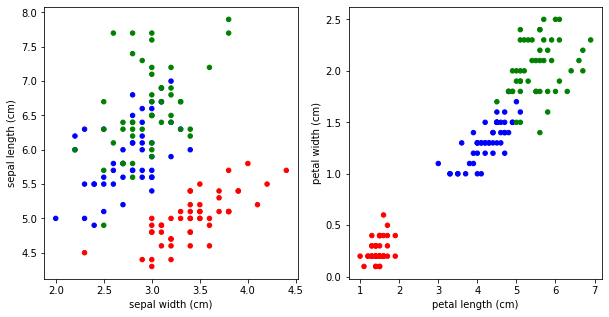

In [283]:
colors=y.copy()
colors[colors==0]='red'
colors[colors==1]='blue'
colors[colors==2]='green'
fig, (ax1, ax2) = plt.subplots(1, 2)
x.plot.scatter(1,0,c = colors, ax=ax1);
x.plot.scatter(2,3,c = colors, ax =ax2);
fig.set_size_inches(10, 5);



## Preprocessing

In [260]:
(x_train, x_test, y_train, y_test) = train_test_split(x,y,test_size=0.3,random_state = 21)

In [261]:
y_test.shape

(45,)

In [262]:
scaler = StandardScaler()
scaler.fit(x_train)

xnorm_train = scaler.transform(x_train)
xnorm_test = scaler.transform(x_test)

xnorm_train = pd.DataFrame(data = xnorm_train, columns = x.columns)
xnorm_test = pd.DataFrame(data = xnorm_test, columns = x.columns)

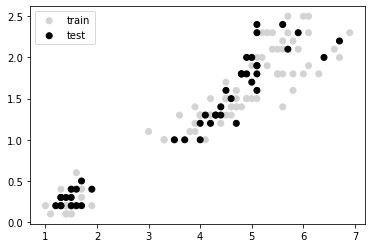

In [263]:
color_train = ["lightgray"]*y_train.size
color_test = ["black"]*y_test.size
fig, axes = plt.subplots()
axes.scatter(x = x_train.iloc[::,2], y = x_train.iloc[::,3], c = color_train);
axes.scatter(x = x_test.iloc[::,2], y = x_test.iloc[::,3], c = color_test);
axes.legend(["train", "test"]);

# Random Forest

In [264]:
model_forest = RandomForestClassifier(n_estimators=100)

scores = cross_val_score(model_forest,xnorm_train,y_train,cv=5)

print("%0.3f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.981 accuracy with a standard deviation of 0.02


In [266]:
model_forest.fit(xnorm_train, y_train)
prediction = model_forest.predict(xnorm_test)

In [267]:
error=[[y_test.iloc[i],prediction[i]] for i in range(y_test.size) if y_test.iloc[i]!=prediction[i] ]
errorDF=pd.DataFrame(data = error, columns= ["True", "Prediction"])
errorDF.set_index(["True"], inplace=True)
errorDF.head(10)

,Prediction
True,
1,2
1,2
1,2


I want to see whcih features are more important. For that, we can use the .feature_importances.

In [324]:
feature_imp = model_forest.feature_importances_
print(dict(zip(x_train.columns,feature_imp)))

{'sepal length (cm)': 0.11091139575916674, 'sepal width (cm)': 0.021821689617543463, 'petal length (cm)': 0.4322914254048286, 'petal width (cm)': 0.4349754892184612}


# SVM

In [329]:
model_vector = SVC(kernel= "linear" ,random_state = 41)
parameters = {"C":np.arange(0.3,3,0.5)}

grid = GridSearchCV(model_vector, parameters, cv=5)

grid.fit(xnorm_train, y_train)

print((grid.best_params_),grid.best_score_)

{'C': 2.8} 0.9904761904761905


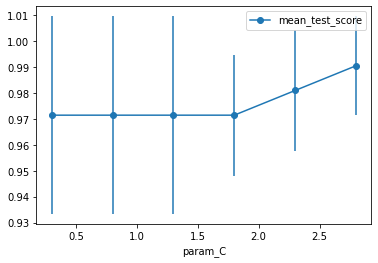

In [330]:
pd.DataFrame(grid.cv_results_).plot(x="param_C",y="mean_test_score",yerr="std_test_score",marker='o');

In [331]:
prediction = grid.best_estimator_.predict(xnorm_test)

error=[[y_test.iloc[i],prediction[i]] for i in range(y_test.size) if y_test.iloc[i]!=prediction[i] ]
errorDF=pd.DataFrame(data = error, columns= ["True", "Prediction"])
errorDF.set_index("True", inplace=True)
errorDF.head(10)

,Prediction
True,
1,2
1,2
1,2


# K-Nearest Neighbour

In [274]:
model_knn = KNeighborsClassifier()
model_knn.fit(xnorm_train,y_train)
parameters = {"n_neighbors":np.arange(2,17,1)}

grid = GridSearchCV(model_knn, parameters,cv=2)

grid.fit(xnorm_train, y_train)

print((grid.best_params_),grid.best_score_)


{'n_neighbors': 7} 0.9620827285921625


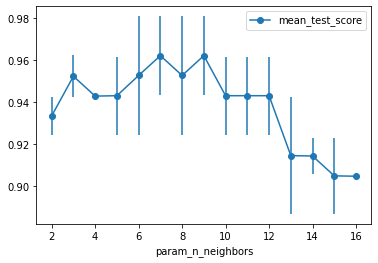

In [275]:
pd.DataFrame(grid.cv_results_).plot(x="param_n_neighbors",y="mean_test_score",yerr="std_test_score",marker='o');
#pd.DataFrame(grid.cv_results_).head()

In [276]:
prediction = grid.best_estimator_.predict(xnorm_test)

error=[[y_test.iloc[i],prediction[i]] for i in range(y_test.size) if y_test.iloc[i]!=prediction[i] ]
errorDF=pd.DataFrame(data = error, columns= ["True", "Prediction"])
errorDF.set_index("True", inplace=True)
errorDF.head(10)

,Prediction
True,
2,1
1,2
2,1
2,1


# PCA

Code stolen from https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

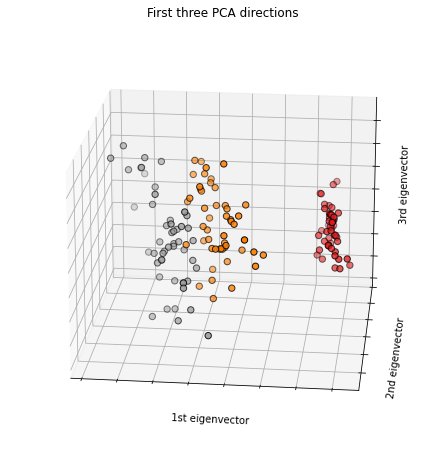

In [293]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-160, azim=84,auto_add_to_figure=False)
fig.add_axes(ax)

X_reduced = PCA(n_components=3).fit_transform(x)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

# Neural Net

In [300]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [332]:
model_nn = Sequential()
model_nn.add(Dense(4,input_dim=4, activation="relu"))
model_nn.add(Dense(7, activation="relu"))
model_nn.add(Dense(3, activation="softmax"))
model_nn.compile(loss="binary_crossentropy", optimizer = "adam", metrics=["accuracy"])

In [333]:
y_test_cat=to_categorical(y_test)
y_train_cat=to_categorical(y_train)

model_nn.fit(x_train, y_train_cat, epochs=200, batch_size=4)
#scores = cross_val_score(model_nn, xnorm_train, y_train_cat, epochs=149)

Epoch 1/200
27/27 [==============================] - 2s 4ms/step - loss: 0.7847 - accuracy: 0.3238
Epoch 2/200
27/27 [==============================] - 0s 6ms/step - loss: 0.7151 - accuracy: 0.3238
Epoch 3/200
27/27 [==============================] - 0s 5ms/step - loss: 0.6621 - accuracy: 0.3238
Epoch 4/200
27/27 [==============================] - 0s 8ms/step - loss: 0.5833 - accuracy: 0.3238
Epoch 5/200
27/27 [==============================] - 0s 6ms/step - loss: 0.4997 - accuracy: 0.6667
Epoch 6/200
27/27 [==============================] - 0s 7ms/step - loss: 0.4537 - accuracy: 0.6667
Epoch 7/200
27/27 [==============================] - 0s 5ms/step - loss: 0.4237 - accuracy: 0.6667
Epoch 8/200
27/27 [==============================] - 0s 9ms/step - loss: 0.4006 - accuracy: 0.6667
Epoch 9/200
27/27 [==============================] - 0s 10ms/step - loss: 0.3812 - accuracy: 0.6667
Epoch 10/200
27/27 [==============================] - 0s 5ms/step - loss: 0.3654 - accuracy: 0.6667
Epoch 11

27/27 [==============================] - 0s 8ms/step - loss: 0.0506 - accuracy: 0.9810
Epoch 162/200
27/27 [==============================] - 0s 9ms/step - loss: 0.0532 - accuracy: 0.9714
Epoch 163/200
27/27 [==============================] - 1s 31ms/step - loss: 0.0514 - accuracy: 0.9810
Epoch 164/200
27/27 [==============================] - 0s 15ms/step - loss: 0.0517 - accuracy: 0.9810
Epoch 165/200
27/27 [==============================] - 0s 6ms/step - loss: 0.0516 - accuracy: 0.9810
Epoch 166/200
27/27 [==============================] - 0s 14ms/step - loss: 0.0506 - accuracy: 0.9810
Epoch 167/200
27/27 [==============================] - 1s 17ms/step - loss: 0.0497 - accuracy: 0.9810
Epoch 168/200
27/27 [==============================] - 0s 19ms/step - loss: 0.0504 - accuracy: 0.9714
Epoch 169/200
27/27 [==============================] - 0s 9ms/step - loss: 0.0497 - accuracy: 0.9810
Epoch 170/200
27/27 [==============================] - 1s 23ms/step - loss: 0.0509 - accuracy: 0.981

In [334]:
_,accuracy = model_nn.evaluate(x_train,y_train_cat)
print("Accuracy: %.2f "%(accuracy*100))

4/4 [==============================] - 0s 67ms/step - loss: 0.0434 - accuracy: 0.9810
Accuracy: 98.10 


In [336]:
model_nn.predict(x_test.iloc[0:10].round(decimals=2))

array([[1.9369556e-06, 9.9998486e-01, 1.3251089e-05],
       [9.9999928e-01, 7.4299237e-07, 5.8445753e-22],
       [9.9999976e-01, 1.9772509e-07, 3.3671847e-22],
       [9.9999988e-01, 1.6713393e-07, 7.2058916e-23],
       [9.8662963e-07, 9.9999881e-01, 2.4471481e-07],
       [3.8472251e-07, 9.9999702e-01, 2.6536818e-06],
       [9.9999952e-01, 4.2668913e-07, 6.4097380e-22],
       [7.2457634e-10, 1.0113578e-03, 9.9898869e-01],
       [9.9999857e-01, 1.4061210e-06, 8.7088548e-21],
       [1.0000000e+00, 4.7819832e-08, 6.2428172e-24]], dtype=float32)

# To do

- Grid search √
- data generation
- neural net √
- look for what people have done online √